In [1]:
using InteractiveUtils
versioninfo()

Julia Version 1.4.2
Commit 44fa15b150* (2020-05-23 18:35 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i5-3210M CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, ivybridge)


In [2]:
using Plots
gr()

Plots.GRBackend()

In [3]:
module PurePersuit

k = 0.1
Lfc = 2.0
Kp = 1.0
dt =0.1
L =2.9

old_nearest_point_index = Nothing

mutable struct State
    x
    y
    yaw
    v
    rear_x
    rear_y
end

function State(x, y, yaw, v)
    state = State(x, y, yaw, v, 0, 0)
    state.rear_x = x - ((L/2) * cos(yaw))
    state.rear_y = y - ((L/2) * sin(yaw))
    return state
end

function update(state, a, delta)
    state.x = state.x + state.v * cos(state.yaw) * dt
    state.y = state.y + state.v * sin(state.yaw) * dt
    state.yaw = state.yaw + state.v / L * tan(delta) * dt
    state.v = state.v + a * dt
    state.rear_x = state.x - ((L/2)*cos(state.yaw))
    state.rear_y = state.y - ((L/2)*sin(state.yaw))
    
    return state
end

function PIDControl(target, current)
    a = Kp * (target - current)
        
    return a
end

function pure_pursuit_control(state, cx, cy, pind)
    ind = calc_target_index(state, cx, cy)            
    if pind >= ind
        ind = pind
    end
    
    if ind<length(cx)
        tx = cx[ind]
        ty = cy[ind]
    else
        tx = cx[-1]
        ty = cy[-1]
        ind = length(cx) - 1
    end
    
    alpha = atan(ty - state.rear_y, tx - state.rear_x) - state.yaw
    
    Lf = k * state.v + Lfc
    
    delta = atan(2.0 * L * sin(alpha) / Lf, 1.0)
    
    return delta, ind
end

function calc_distance(state, point_x, point_y)
    dx = state.rear_x - point_x
    dy = state.rear_y - point_y
    return sqrt(dx^2 + dy^2)
end 

function calc_target_index(state, cx, cy)
    
    global old_nearest_point_index
    
    if old_nearest_point_index == Nothing
        dx = [state.rear_x - icx for icx in cx]
        dy = [state.rear_y - icy for icy in cy]
        d = [abs(sqrt(idx^2 + idy^2)) for (idx, idy) in zip(dx, dy)]
        ind = argmin(d) # ind = d.index(minimum(d))
        old_nearest_point_index = ind
    else
        ind = old_nearest_point_index
        distance_this_index = calc_distance(state, cx[ind], cy[ind])
        while true
            if (ind + 1) < length(cx)
                ind = ind + 1 
            else
                ind
            end
            distance_next_index = calc_distance(state, cx[ind], cy[ind])
            if distance_this_index < distance_next_index
                break
            end
            
            distance_this_index = distance_next_index
        end
        old_nearest_point_index = ind    
    end
    
    L = 0.0
    
    Lf = k * state.v + Lfc
   
    while (Lf > L) && (ind + 1 < length(cx))
        dx = cx[ind] - state.rear_x
        dy = cy[ind] - state.rear_y
        L = sqrt(dx^2 + dy^2)
        ind += 1
    end
    
    return ind
    
end

function plot_arrow(x, y, way, length=1.0, width=0.5, fc="r", ec="k")
    
end

function control(cx, cy, target_speed, T)
    
    state = State(0.0, -3.0, 0.0, 0.0)

    lastIndex = length(cx) - 1
    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [time]
    target_ind = PurePersuit.calc_target_index(state, cx, cy)

    while (T >= time) && (lastIndex > target_ind)
        ai = PurePersuit.PIDControl(target_speed, state.v)
        di, target_ind = PurePersuit.pure_pursuit_control(state, cx, cy, target_ind)
        state = PurePersuit.update(state, ai, di)

        time = time + dt

        append!(x, state.x)
        append!(y, state.y)
        append!(yaw, state.yaw)
        append!(v, state.v)
        append!(t, time)

    end
    
    return x, y, v
end

end

Main.PurePersuit

In [4]:
cx = Array(0:0.1:50)
cy = [sin(ix/5.0) * ix / 2.0 for ix in cx]

target_speed = 10.0 / 3.6

T = 100.0

x, y, v = PurePersuit.control(cx, cy, target_speed, T)

([0.0, 0.0, 0.02777777777777778, 0.08054075496761086, 0.15564866207624453, 0.2504092924427207, 0.3619166949175993, 0.4869865007300865, 0.6221986614570028, 0.7640270094354836  …  47.38453545567894, 47.44223742464396, 47.49987813517073, 47.557470916682966, 47.61502967253119, 47.67256872027931, 47.73010266826871, 47.78764632259412, 47.8452146193069, 47.90282257733808], [-3.0, -3.0, -3.0, -2.99875017392184, -2.9936958572596835, -2.9816136695559363, -2.9591238130542616, -2.923096878582436, -2.870955134760604, -2.800861741197401  …  -1.330562547481701, -1.6022811088733009, -1.8740126718488406, -2.1457543972883553, -2.417503331881234, -2.689256440072107, -2.9610106279991992, -3.232762760785748, -3.504509674366656, -3.7762481828608303], [0.0, 0.2777777777777778, 0.5277777777777778, 0.7527777777777778, 0.9552777777777778, 1.1375277777777777, 1.3015527777777778, 1.4491752777777778, 1.5820355277777778, 1.7016097527777778  …  2.777777777777776, 2.777777777777776, 2.777777777777776, 2.7777777777777

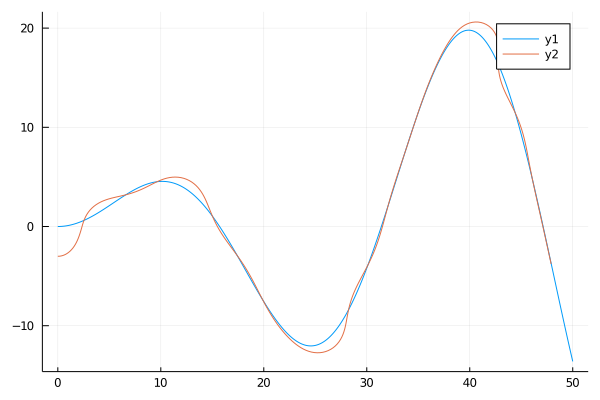

In [5]:
plot(cx, cy)
plot!(x, y)

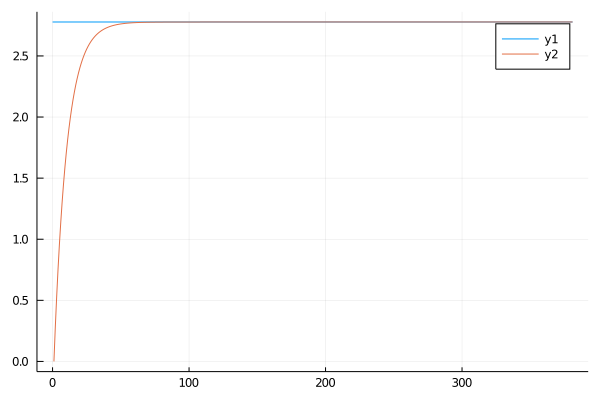

In [6]:
plot([0, length(v)], [target_speed, target_speed])
plot!(v)